In [41]:
!pip install torch_snippets

In [42]:
import torch
from torch import nn
import torchvision
import seaborn as sns
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch_snippets import *
from torchvision import transforms
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/MyDrive/AI-CA5-Dataset'

In [43]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
KERNEL_SIZE = 3
PADDING_SIZE = 1
POOL_SIZE = 2
NUM_CLASSES = 4
LEARNING_RATE = 0.001

## **Preprocessing Data**


We have split the data into a 80-20 train-test ratio because our dataset is not very large. If we use less than 80% of the data for training, it might not be sufficient to effectively train the model.÷

In [44]:
class MyDataset(Dataset):
    def __init__(self, transform, root_dir=dataset_path, split='Training', split_ratio=0.8):
        self.root_dir = dataset_path
        self.categories = os.listdir(self.root_dir)
        self.transform = transform
        self.split = split
        self.int2category = {}
        self.split_ratio = split_ratio
        self.data = self.load_data()

    def load_data(self):
        data = []
        for i, category in enumerate(self.categories):
            category_path = os.path.join(self.root_dir, category)
            self.int2category[i] = category
            files = os.listdir(category_path)
            split_index = int(len(files) * self.split_ratio)
            if self.split == 'Training':
                files = files[:split_index]
            else:
                files = files[split_index:]
            for file_name in files:
                img_path = os.path.join(category_path, file_name)
                data.append([img_path, i])
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("L")
        label = torch.tensor(label)
        if self.transform:
            transformed_image = self.transform(image)
        return transformed_image.to(device), label.to(device)

    def plot_data_distribution(self):
      category_counts = { x : 0 for x in self.int2category.values()}
      for img_path , i  in self.data:
          category_counts[self.int2category[i]] += 1
      plt.figure(figsize=(10,5))
      plt.bar(category_counts.keys(), category_counts.values())
      plt.title('Number of files in each category')
      plt.xlabel('Category - ' + self.split)
      plt.ylabel('Number of files')
      plt.xticks(rotation=90)
      plt.show()


**Advantages**:

1. **Learning Efficiency**: Normalization ensures that all input features (pixels, in this case) are on the same scale, which makes the learning process more efficient. This is because the learning rate would cause corrections in each dimension that would differ from one another if we didn't scale our input training vectors.

2. **Improved Performance**: Normalization can significantly improve the performance of CNNs in image classification tasks. This is because normalization ensures that the optimization algorithm (like gradient descent) converges faster, leading to more efficient training of the network¹.

3. **Data Consistency**: Normalization ensures that data from different formats (or datasets) are normalized so you can apply the same algorithms over them.

**Disadvantages**:

1. **Increased Complexity**: While normalization makes databases more efficient to support, they can also make them more complex because data is divided into so many different tables.

2. **Data Loss**: In some cases, normalization can lead to loss of information if not done properly.

3. **Computationally Intensive**: Normalization can be computationally intensive, especially for large datasets¹.


In [47]:
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ColorJitter(brightness=(0.8,1.2),
                            contrast=(0.8,1.2),
                            saturation=(0.8,1.2),
                            hue=0.25),
    transforms.RandomAffine(5, translate=(0.01,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

train_dataset = MyDataset(train_transform , root_dir=dataset_path, split='Training')
test_dataset = MyDataset(test_transform , root_dir=dataset_path, split='Testing')

In [48]:
int2category = train_dataset.int2category
categories = os.listdir(dataset_path)

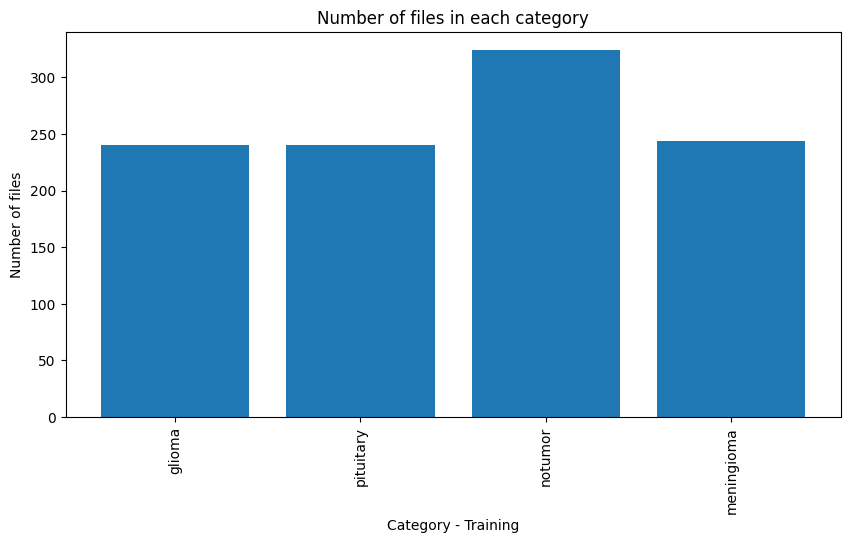

In [49]:
train_dataset.plot_data_distribution()

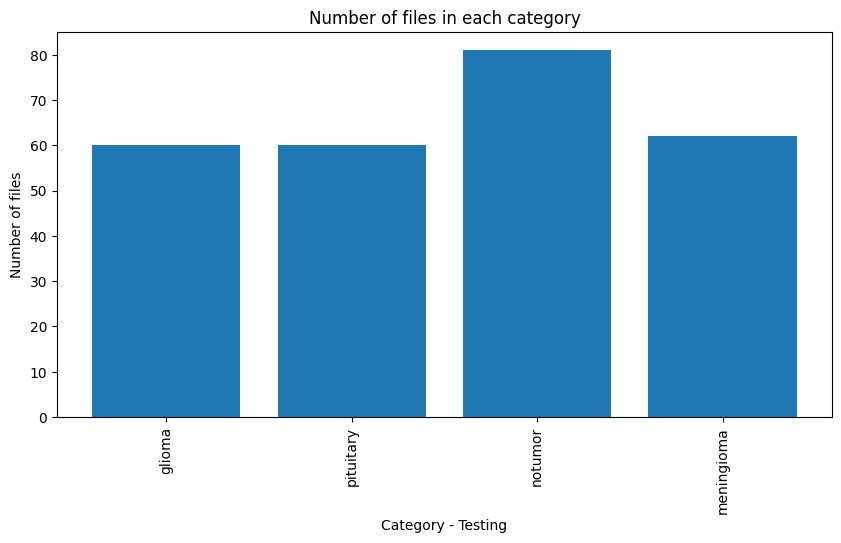

In [50]:
test_dataset.plot_data_distribution()

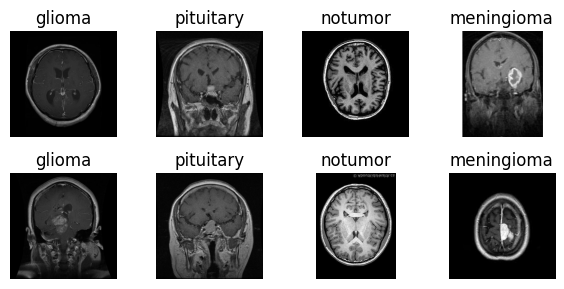

In [51]:
fig , axes = plt.subplots(2,4, figsize = (6,3))
for i in range(len(categories)):
    for j in range(2):
        category_path = os.path.join(dataset_path, categories[i])
        category_images = random.sample(os.listdir(category_path) , 1)[0]
        random_image = os.path.join(category_path , category_images)
        axes[j , i].imshow(Image.open(random_image).convert("L") , cmap = 'gray')
        axes[j , i].set_title(categories[i])
        axes[j , i].set_axis_off()
plt.tight_layout()

## **CNN**

1. **Convolutional Layer**: This is the major block of a CNN that applies a filter to an image, and the result contains the strength of the image’s features.

 The convolutional layer applies a set of learnable filters, also known as kernels, toy. Each filter is convolved along the width and height of the input image, calculating a sum of element-wise multiplication

2. **Activation Function**: The activation function applies non-linearity into the output of neuron. if we don't use it and use some linear layers then it's same aswhen we just use only one linear layer.
3. **Pooling Layer**: The pooling layer downsamples the image to reduce computation2. It helps to make the representation become approximately invariant to small translations of the input.
4. **Fully Connected Layer**: In a fully connected layer, each neuron applies a linear transformation to the input vector through a weights matrix.

We set the kernel size to 3, it means our kernel is a 3x3 matrix. The default stride is typically set to 1. Padding is used to apply the kernel to border pixels as well, ensuring that the spatial dimensions (i.e., width and height) of the output feature map are the same as the input.

### **Activation Functions**
1. **ReLU (Rectified Linear Unit)**:
It is the most commonly used activation function in CNNs.
It introduces non-linearity without affecting the receptive fields of the convolution layer.
It returns 0 if it receives any negative input, but for any positive value x it returns that value back.
It is computationally efficient because it allows the network to converge very quickly.
It has a problem called the “Dying ReLU” problem where neurons can sometimes be stuck in the negative state and always output 0.

2. **Sigmoid**:
It is useful in the case of binary classification as its output values lie between 0 and 1.
It is not zero-centered which can sometimes be problematic during the gradient descent.
It has a vanishing gradient problem where the gradient becomes very small, almost zero, for very high or very low values.

3. **Tanh (Hyperbolic Tangent)**:
The range of the tanh function is from (-1 to 1) which makes it easier to model inputs that have strongly negative, neutral, and strongly positive values.
It is zero-centered making it easier for the model to learn from backpropagated errors.
Like sigmoid, it also has the vanishing gradient problem.

4. **Softmax**:
This function is useful in the output layer of the network for multi-class classification problems.
It gives the probability distribution of the event over ‘n’ different events1.
It is more useful in the output layer, especially for multi-class classification problems

5. **Leaky ReLU**: This is a variant of ReLU that solves the “Dying ReLU” problem. Instead of defining the function as 0 for negative values of x, it defines it as a small linear component of x.

6. **Parametric ReLU (PReLU)**: This is another variant of ReLU that solves the “Dying ReLU” problem. It allows the negative slope to be learned. Unlike Leaky ReLU, this function provides the slope of the negative part of the function as an argument.

7. **Exponential Linear Units (ELUs)**: ELU tries to make the mean activations closer to zero which speeds up learning. It has been observed that the network that used ELU activation function, the learning process was faster.

8. **Scaled Exponential Linear Units (SELUs)**: SELU activation function is a scaled variant of the ELU function. The output of the function is scaled in a way that the mean output activation is zero and the standard deviation is one.

9. **Swish**: This is a self-gated activation function introduced by researchers at Google. Swish is as computationally efficient as ReLU and shows better performance than ReLU on deeper models. The formula for calculation is swish(x) = x * sigmoid(x).

10. **Maxout**: The Maxout activation is a generalization of the ReLU and the leaky ReLU functions. It is a learnable activation function, that could learn to approximate several types of activation functions such as ReLU, leaky ReLU, etc.

11. **SoftPlus**: Softplus is a smooth approximation to the ReLU function and can be useful when you care about differentiability

In [52]:
def conv_pool_block(ni , no):
    return nn.Sequential(
        nn.Conv2d(ni , no , kernel_size = KERNEL_SIZE , padding = PADDING_SIZE),
        nn.ReLU(),
        nn.MaxPool2d(POOL_SIZE, POOL_SIZE)
    )

In [53]:
class BrainTumerClassifier(nn.Module):
    def __init__(self  , num_classes):
        super().__init__()
        self.model = nn.Sequential(
            conv_pool_block(1  , 32) ,
            conv_pool_block(32 , 32) ,
            conv_pool_block(32 , 64) ,
            conv_pool_block(64 , 64) ,
            nn.Flatten() ,
            nn.Linear(32 * 32 * 64 , num_classes)
        )
    def forward(self, x):
        return self.model(x)

Given that deep neural networks require a large amount of data for training, and our data was limited, we aimed to simplify our network. Therefore, the number of layers, especially in the fully connected section, is reduced. Also, in the convolutional section, we arranged the number of layers in such a way that based on the pooling layer, our data would be reduced to a size that we could use and avoid memory errors. This allows our calculations to be performed at a faster speed.

In [54]:
model = BrainTumerClassifier(num_classes = NUM_CLASSES).to(device)

## **Loss Functions**
1. **Regression Loss Functions**:

  - **Mean Squared Error Loss**: It is used for regression problems. It calculates the square of the difference between the actual and the predicted values.
  - **Mean Squared Logarithmic Error Loss**: It calculates the logarithm of the predicted value and then squares the difference with the actual value. It is less sensitive to outliers than Mean Squared Error Loss.
  - **Mean Absolute Error Loss**: It calculates the absolute difference between the actual and the predicted values. It is robust to outliers.
2. **Binary Classification Loss Functions**:

  - Binary Cross-Entropy: It is the default loss function for binary classification problems1. It calculates the cross-entropy loss between true labels and predicted labels.
  - Hinge Loss: It is used for training classifiers. The hinge loss function encourages a model to correctly classify its training data.
  - Squared Hinge Loss: It is the square of the hinge loss.
3. **Multi-Class Classification Loss Functions**:

  - **Multi-Class Cross-Entropy Loss**: It is used when a classification problem has more than two classes. It calculates the cross-entropy loss between true labels and predicted labels.
  - **Sparse Multiclass Cross-Entropy Loss**: It is a variant of Multi-Class Cross-Entropy Loss that can be used when integer class labels are used instead of one-hot encoded labels.
  - **Kullback Leibler Divergence Loss**: It calculates the Kullback-Leibler divergence between the true and predicted probability distributions.
4. **Other Loss Functions**:

  - Categorical Hinge Loss
  - Logcosh Loss
  - Categorical Crossentropy
  - Sparse Categorical Crossentropy

In [55]:
lossfunction = nn.CrossEntropyLoss()

## **Optimizer**

**Stochastic Gradient Descent (SGD**) is a type of gradient descent algorithm that estimates the error gradient for the current state of the model using a subset of the data, and then updates the model parameters using this estimated error gradient. The learning rate in SGD does not change throughout training. It’s the most basic form of Gradient Descent where the weights are updated by subtracting the gradient multiplied by the learning rate from the weights.

**Adam**, which stands for Adaptive Moment Estimation, is an extension of SGD that uses adaptive learning rates for different parameters. It computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients. Adam combines the advantages of two other extensions of SGD, RMSProp and Momentum, by storing both the individual learning rate of RMSProp and the weighted average of momentum.

The main differences between SGD and Adam are:

- **Learning Rate**: In SGD, all parameters have the same learning rate which remains constant throughout the training. On the other hand, Adam maintains a separate learning rate for each parameter and adaptively changes it during training.

- **Convergence Speed and Generalization**: Adam is often faster to converge and shows better optimization performance than SGD in some scenarios. However, SGD is known to generalize better than Adam.

- **Memory Requirement**: Adam stores an exponentially decaying average of past gradients and past squared gradients, thus requiring more memory than SGD.

- **Noise Handling**: Adam is well suited for problems with very noisy or sparse gradients.

In [56]:
optimizer = torch.optim.Adam(model.parameters() , lr = LEARNING_RATE)

In [57]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [58]:
def plot2l(list1, list2, label1, label2, title):
    fig, ax = plt.subplots()

    ax.plot(list1, 'r', label=label1)
    ax.plot(list2, 'b', label=label2)

    ax.legend()
    ax.set_title(title)

    plt.show()

In [59]:
def plot_confusion_matrix(genres,predicted):
    plt.figure(figsize=(10,7))
    sns.heatmap(predicted, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues', xticklabels=genres, yticklabels=genres);
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title('Confusion Matrix', size = 15);
    plt.show()

In [60]:
def calculate_classification_metrics(genres, confusion_matrix):
    total_elements = np.sum(confusion_matrix)
    accuracy = np.trace(confusion_matrix) / total_elements
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)

    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1)

    support = np.sum(confusion_matrix, axis=1)
    precision_weighted = np.sum(precision * support) / np.sum(support)
    recall_weighted = np.sum(recall * support) / np.sum(support)
    f1_weighted = np.sum(f1 * support) / np.sum(support)

    precision_micro = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
    recall_micro = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
    f1_micro = 2 * (precision_micro * recall_micro) / (precision_micro + recall_micro)

    metrics_per_class = pd.DataFrame({
        'Genre': genres,
        'Accuracy' : accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    average_metrics = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Macro Average': [precision_macro, recall_macro, f1_macro],
        'Weighted Average': [precision_weighted, recall_weighted, f1_weighted],
        'Micro Average': [precision_micro, recall_micro, f1_micro]
    })

    return metrics_per_class, average_metrics

In [61]:
def train_model(model , train_loader, test_loader, optimizer, lossfunction):
    confusion_matrix_train = np.zeros((NUM_CLASSES, NUM_CLASSES))
    confusion_matrix_test = np.zeros((NUM_CLASSES, NUM_CLASSES))
    losses = { 'Train' : [] , 'Test' : []}
    accuracies = { 'Train' : [] , 'Test' : []}

    for epoch in tqdm(range(NUM_EPOCHS), desc='Epochs'):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        confusion_matrix_train = np.zeros((NUM_CLASSES, NUM_CLASSES))
        confusion_matrix_test = np.zeros((NUM_CLASSES, NUM_CLASSES))
        for batch_index, data in enumerate(train_loader):
            inputs , labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lossfunction(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, prediction = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (prediction == labels).sum().item()

            for t, p in zip(labels.view(-1), prediction.view(-1)):
                confusion_matrix_train[t.long(), p.long()] += 1
        train_accuracy = correct / total
        accuracies['Train'].append(train_accuracy)
        losses['Train'].append(train_loss)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():

            for batch_idx, data in enumerate(test_loader):
                inputs, labels = data
                outputs = model(inputs)
                loss = lossfunction(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs , 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for t, p in zip(labels.view(-1), predicted.view(-1)):
                    confusion_matrix_test[t.long(), p.long()] += 1

        test_accuracy = correct / total
        losses['Test'].append(test_loss)
        accuracies['Test'].append(test_accuracy)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}')

    return accuracies, losses, confusion_matrix_train, confusion_matrix_test

In [62]:
accuracies, losses, confusion_matrix_train, confusion_matrix_test = train_model(model , train_loader, test_loader, optimizer, lossfunction)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Training Loss: 21.5253, Training Accuracy: 45.61%, Test Loss: 4.2275, Test Accuracy: 66.54%

Epochs:   3%|▎         | 1/30 [00:15<07:37, 15.77s/it]

Epoch [2/30], Training Loss: 16.1616, Training Accuracy: 63.55%, Test Loss: 4.9207, Test Accuracy: 67.68%

Epochs:   7%|▋         | 2/30 [00:31<07:19, 15.70s/it]

Epoch [3/30], Training Loss: 13.5879, Training Accuracy: 68.80%, Test Loss: 3.7535, Test Accuracy: 69.20%

Epochs:  10%|█         | 3/30 [00:48<07:25, 16.50s/it]

Epoch [4/30], Training Loss: 12.9870, Training Accuracy: 68.89%, Test Loss: 3.4367, Test Accuracy: 72.24%

Epochs:  13%|█▎        | 4/30 [01:04<07:00, 16.17s/it]

Epoch [5/30], Training Loss: 11.8450, Training Accuracy: 72.81%, Test Loss: 3.7132, Test Accuracy: 73.38%

Epochs:  17%|█▋        | 5/30 [01:20<06:40, 16.02s/it]

Epoch [6/30], Training Loss: 10.9016, Training Accuracy: 74.71%, Test Loss: 3.1661, Test Accuracy: 73.76%

Epochs:  20%|██        | 6/30 [01:35<06:21, 15.88s/it]

Epoch [7/30], Training Loss: 10.1398, Training Accuracy: 76.34%, Test Loss: 3.3638, Test Accuracy: 74.14%

Epochs:  23%|██▎       | 7/30 [01:51<06:03, 15.81s/it]

Epoch [8/30], Training Loss: 8.7699, Training Accuracy: 80.92%, Test Loss: 2.8451, Test Accuracy: 77.19%

Epochs:  27%|██▋       | 8/30 [02:07<05:47, 15.78s/it]

Epoch [9/30], Training Loss: 9.3112, Training Accuracy: 78.44%, Test Loss: 3.4877, Test Accuracy: 74.90%

Epochs:  30%|███       | 9/30 [02:22<05:30, 15.75s/it]

Epoch [10/30], Training Loss: 8.5082, Training Accuracy: 81.87%, Test Loss: 3.2112, Test Accuracy: 80.99%

Epochs:  33%|███▎      | 10/30 [02:38<05:14, 15.73s/it]

Epoch [11/30], Training Loss: 7.7365, Training Accuracy: 83.49%, Test Loss: 2.9328, Test Accuracy: 77.57%

Epochs:  37%|███▋      | 11/30 [02:54<04:57, 15.66s/it]

Epoch [12/30], Training Loss: 7.4363, Training Accuracy: 83.30%, Test Loss: 2.7838, Test Accuracy: 75.29%

Epochs:  40%|████      | 12/30 [03:09<04:42, 15.67s/it]

Epoch [13/30], Training Loss: 7.8589, Training Accuracy: 82.63%, Test Loss: 2.7635, Test Accuracy: 77.95%

Epochs:  43%|████▎     | 13/30 [03:25<04:26, 15.70s/it]

Epoch [14/30], Training Loss: 7.1100, Training Accuracy: 85.11%, Test Loss: 2.5319, Test Accuracy: 78.71%

Epochs:  47%|████▋     | 14/30 [03:41<04:11, 15.72s/it]

Epoch [15/30], Training Loss: 6.5381, Training Accuracy: 85.40%, Test Loss: 4.0980, Test Accuracy: 72.62%

Epochs:  50%|█████     | 15/30 [03:57<03:56, 15.78s/it]

Epoch [16/30], Training Loss: 6.9634, Training Accuracy: 83.40%, Test Loss: 2.7934, Test Accuracy: 79.85%

Epochs:  53%|█████▎    | 16/30 [04:13<03:41, 15.81s/it]

Epoch [17/30], Training Loss: 6.1705, Training Accuracy: 85.78%, Test Loss: 3.3773, Test Accuracy: 77.57%

Epochs:  57%|█████▋    | 17/30 [04:29<03:25, 15.81s/it]

Epoch [18/30], Training Loss: 6.7039, Training Accuracy: 85.97%, Test Loss: 3.2243, Test Accuracy: 79.09%

Epochs:  60%|██████    | 18/30 [04:44<03:10, 15.84s/it]

Epoch [19/30], Training Loss: 5.3410, Training Accuracy: 87.98%, Test Loss: 2.5541, Test Accuracy: 84.03%

Epochs:  63%|██████▎   | 19/30 [05:00<02:53, 15.81s/it]

Epoch [20/30], Training Loss: 5.9657, Training Accuracy: 86.55%, Test Loss: 2.4098, Test Accuracy: 78.33%

Epochs:  67%|██████▋   | 20/30 [05:16<02:38, 15.80s/it]

Epoch [21/30], Training Loss: 5.9911, Training Accuracy: 87.50%, Test Loss: 2.0191, Test Accuracy: 82.13%

Epochs:  70%|███████   | 21/30 [05:32<02:22, 15.82s/it]

Epoch [22/30], Training Loss: 5.2362, Training Accuracy: 88.36%, Test Loss: 4.0134, Test Accuracy: 81.37%

Epochs:  73%|███████▎  | 22/30 [05:48<02:06, 15.82s/it]

Epoch [23/30], Training Loss: 4.0681, Training Accuracy: 91.51%, Test Loss: 2.8963, Test Accuracy: 78.71%

Epochs:  77%|███████▋  | 23/30 [06:03<01:50, 15.82s/it]

Epoch [24/30], Training Loss: 4.3127, Training Accuracy: 91.51%, Test Loss: 2.1473, Test Accuracy: 85.17%

Epochs:  80%|████████  | 24/30 [06:19<01:35, 15.85s/it]

Epoch [25/30], Training Loss: 4.3439, Training Accuracy: 90.46%, Test Loss: 2.4732, Test Accuracy: 82.51%

Epochs:  83%|████████▎ | 25/30 [06:35<01:19, 15.81s/it]

Epoch [26/30], Training Loss: 4.4762, Training Accuracy: 90.36%, Test Loss: 2.8834, Test Accuracy: 80.99%

Epochs:  87%|████████▋ | 26/30 [06:51<01:02, 15.75s/it]

Epoch [27/30], Training Loss: 3.5103, Training Accuracy: 91.89%, Test Loss: 2.4870, Test Accuracy: 83.27%

Epochs:  90%|█████████ | 27/30 [07:06<00:47, 15.73s/it]

Epoch [28/30], Training Loss: 3.4293, Training Accuracy: 92.56%, Test Loss: 2.6358, Test Accuracy: 80.61%

Epochs:  93%|█████████▎| 28/30 [07:22<00:31, 15.73s/it]

Epoch [29/30], Training Loss: 3.8831, Training Accuracy: 91.41%, Test Loss: 2.5034, Test Accuracy: 84.03%

Epochs:  97%|█████████▋| 29/30 [07:43<00:17, 17.33s/it]

Epoch [30/30], Training Loss: 3.4918, Training Accuracy: 92.37%, Test Loss: 2.1990, Test Accuracy: 84.03%

Epochs: 100%|██████████| 30/30 [07:59<00:00, 15.98s/it]


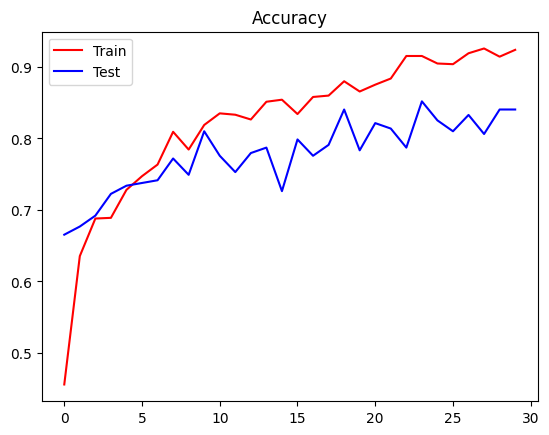

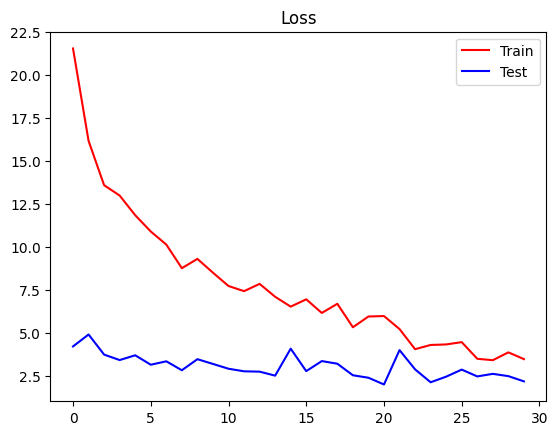

In [63]:
plot2l(accuracies['Train'], accuracies['Test'],'Train', 'Test', 'Accuracy')
plot2l(losses['Train'], losses['Test'], 'Train', 'Test', 'Loss')

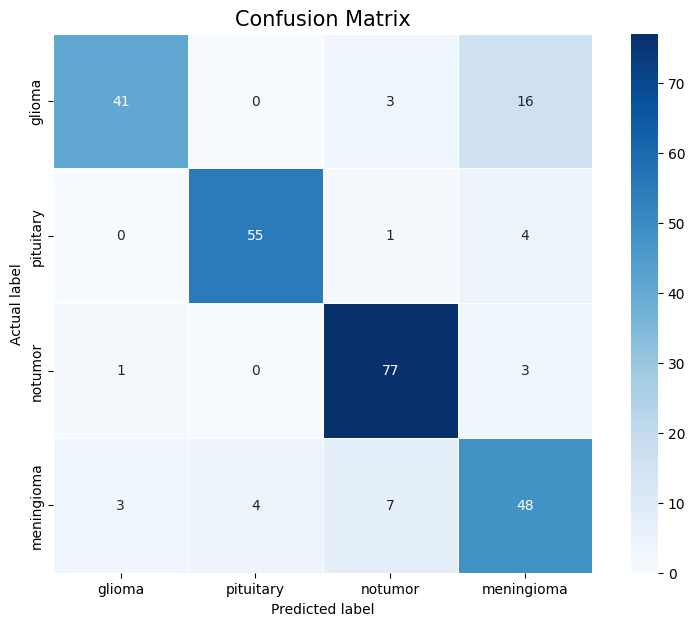

In [64]:
plot_confusion_matrix(categories ,confusion_matrix_test)

In [65]:
metrics_per_class, average_metrics = calculate_classification_metrics(categories, confusion_matrix_test)

In [66]:
metrics_per_class

,Genre,Accuracy,Precision,Recall,F1 Score
0,glioma,0.840304,0.911111,0.683333,0.780952
1,pituitary,0.840304,0.932203,0.916667,0.924370
2,notumor,0.840304,0.875000,0.950617,0.911243
3,meningioma,0.840304,0.676056,0.774194,0.721805


In [67]:
average_metrics

,Metric,Macro Average,Weighted Average,Micro Average
0,Precision,0.848593,0.849389,0.840304
1,Recall,0.831203,0.840304,0.840304
2,F1 Score,0.834592,0.839855,0.840304


In [68]:
def conv_pool_block2(ni , no):
    return nn.Sequential(
        nn.Conv2d(ni , no , kernel_size = KERNEL_SIZE , padding = PADDING_SIZE),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(POOL_SIZE)
    )

In [73]:
class BrainTumerClassifier2(nn.Module):
    def __init__(self  , num_classes, p =0.2):
        super().__init__()
        self.model = nn.Sequential(
            conv_pool_block2(1  , 32) ,
            conv_pool_block2(32 , 32) ,
            conv_pool_block2(32 , 64) ,
            conv_pool_block2(64 , 64) ,
            nn.Flatten() ,
            nn.Dropout(p, inplace=True),
            nn.Linear(32 * 32 * 64 , num_classes)
        )
    def forward(self, x):
        return self.model(x)

In [74]:
model2 = BrainTumerClassifier2(num_classes = NUM_CLASSES).to(device)

In [75]:
optimizer2 = torch.optim.Adam(model2.parameters() , lr = LEARNING_RATE)

In [76]:
accuracies2, losses2, confusion_matrix_train2, confusion_matrix_test2 = train_model(model2 , train_loader, test_loader, optimizer2, lossfunction)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Training Loss: 137.8004, Training Accuracy: 43.61%, Test Loss: 6.3847, Test Accuracy: 58.56%

Epochs:   3%|▎         | 1/30 [00:17<08:33, 17.70s/it]

Epoch [2/30], Training Loss: 61.3950, Training Accuracy: 60.11%, Test Loss: 13.0816, Test Accuracy: 62.36%

Epochs:   7%|▋         | 2/30 [00:35<08:21, 17.92s/it]

Epoch [3/30], Training Loss: 42.4293, Training Accuracy: 68.13%, Test Loss: 8.5985, Test Accuracy: 70.72%

Epochs:  10%|█         | 3/30 [00:53<08:02, 17.89s/it]

Epoch [4/30], Training Loss: 38.4076, Training Accuracy: 72.14%, Test Loss: 14.3266, Test Accuracy: 61.98%

Epochs:  13%|█▎        | 4/30 [01:11<07:43, 17.84s/it]

Epoch [5/30], Training Loss: 34.8648, Training Accuracy: 72.90%, Test Loss: 8.1455, Test Accuracy: 73.00%

Epochs:  17%|█▋        | 5/30 [01:29<07:25, 17.83s/it]

Epoch [6/30], Training Loss: 35.5006, Training Accuracy: 73.19%, Test Loss: 7.5117, Test Accuracy: 76.81%

Epochs:  20%|██        | 6/30 [01:47<07:08, 17.84s/it]

Epoch [7/30], Training Loss: 35.1726, Training Accuracy: 77.19%, Test Loss: 29.5031, Test Accuracy: 67.68%

Epochs:  23%|██▎       | 7/30 [02:05<06:53, 17.99s/it]

Epoch [8/30], Training Loss: 35.1192, Training Accuracy: 75.00%, Test Loss: 13.1708, Test Accuracy: 70.34%

Epochs:  27%|██▋       | 8/30 [02:23<06:34, 17.95s/it]

Epoch [9/30], Training Loss: 27.6071, Training Accuracy: 79.10%, Test Loss: 12.2414, Test Accuracy: 74.14%

Epochs:  30%|███       | 9/30 [02:40<06:15, 17.88s/it]

Epoch [10/30], Training Loss: 28.9760, Training Accuracy: 76.81%, Test Loss: 15.7623, Test Accuracy: 71.86%

Epochs:  33%|███▎      | 10/30 [02:58<05:56, 17.83s/it]

Epoch [11/30], Training Loss: 34.9351, Training Accuracy: 75.57%, Test Loss: 16.4531, Test Accuracy: 68.44%

Epochs:  37%|███▋      | 11/30 [03:16<05:40, 17.95s/it]

Epoch [12/30], Training Loss: 41.8658, Training Accuracy: 75.29%, Test Loss: 7.6735, Test Accuracy: 75.67%

Epochs:  40%|████      | 12/30 [03:35<05:24, 18.03s/it]

Epoch [13/30], Training Loss: 27.1930, Training Accuracy: 79.10%, Test Loss: 16.4347, Test Accuracy: 77.57%

Epochs:  43%|████▎     | 13/30 [03:52<05:05, 17.97s/it]

Epoch [14/30], Training Loss: 24.8968, Training Accuracy: 82.25%, Test Loss: 8.6681, Test Accuracy: 70.72%

Epochs:  47%|████▋     | 14/30 [04:10<04:46, 17.92s/it]

Epoch [15/30], Training Loss: 29.1385, Training Accuracy: 79.20%, Test Loss: 11.6606, Test Accuracy: 73.76%

Epochs:  50%|█████     | 15/30 [04:28<04:28, 17.90s/it]

Epoch [16/30], Training Loss: 28.0534, Training Accuracy: 78.82%, Test Loss: 23.4100, Test Accuracy: 73.76%

Epochs:  53%|█████▎    | 16/30 [04:46<04:12, 18.02s/it]

Epoch [17/30], Training Loss: 25.5915, Training Accuracy: 83.78%, Test Loss: 24.2883, Test Accuracy: 71.48%

Epochs:  57%|█████▋    | 17/30 [05:04<03:54, 18.00s/it]

Epoch [18/30], Training Loss: 31.0825, Training Accuracy: 79.48%, Test Loss: 10.2307, Test Accuracy: 76.43%

Epochs:  60%|██████    | 18/30 [05:22<03:35, 17.92s/it]

Epoch [19/30], Training Loss: 23.9031, Training Accuracy: 83.02%, Test Loss: 13.6744, Test Accuracy: 73.38%

Epochs:  63%|██████▎   | 19/30 [05:40<03:16, 17.87s/it]

Epoch [20/30], Training Loss: 28.5193, Training Accuracy: 82.06%, Test Loss: 14.8887, Test Accuracy: 76.43%

Epochs:  67%|██████▋   | 20/30 [05:58<02:59, 17.95s/it]

Epoch [21/30], Training Loss: 20.2980, Training Accuracy: 84.16%, Test Loss: 18.6428, Test Accuracy: 71.10%

Epochs:  70%|███████   | 21/30 [06:16<02:42, 18.09s/it]

Epoch [22/30], Training Loss: 22.9699, Training Accuracy: 82.63%, Test Loss: 8.1233, Test Accuracy: 78.33%

Epochs:  73%|███████▎  | 22/30 [06:35<02:24, 18.10s/it]

Epoch [23/30], Training Loss: 17.3942, Training Accuracy: 86.45%, Test Loss: 8.6976, Test Accuracy: 77.19%

Epochs:  77%|███████▋  | 23/30 [06:52<02:06, 18.07s/it]

Epoch [24/30], Training Loss: 12.9504, Training Accuracy: 88.84%, Test Loss: 16.4730, Test Accuracy: 76.05%

Epochs:  80%|████████  | 24/30 [07:10<01:48, 18.01s/it]

Epoch [25/30], Training Loss: 22.4643, Training Accuracy: 85.31%, Test Loss: 32.0419, Test Accuracy: 74.90%

Epochs:  83%|████████▎ | 25/30 [07:29<01:30, 18.06s/it]

Epoch [26/30], Training Loss: 27.2303, Training Accuracy: 81.30%, Test Loss: 12.9167, Test Accuracy: 72.24%

Epochs:  87%|████████▋ | 26/30 [07:47<01:12, 18.04s/it]

Epoch [27/30], Training Loss: 23.1235, Training Accuracy: 85.31%, Test Loss: 9.2383, Test Accuracy: 75.29%

Epochs:  90%|█████████ | 27/30 [08:05<00:54, 18.25s/it]

Epoch [28/30], Training Loss: 17.1832, Training Accuracy: 86.55%, Test Loss: 6.1339, Test Accuracy: 82.13%

Epochs:  93%|█████████▎| 28/30 [08:23<00:36, 18.10s/it]

Epoch [29/30], Training Loss: 15.0689, Training Accuracy: 87.40%, Test Loss: 7.4678, Test Accuracy: 79.85%

Epochs:  97%|█████████▋| 29/30 [08:41<00:18, 18.07s/it]

Epoch [30/30], Training Loss: 13.0233, Training Accuracy: 88.17%, Test Loss: 6.8872, Test Accuracy: 81.75%

Epochs: 100%|██████████| 30/30 [08:59<00:00, 17.99s/it]


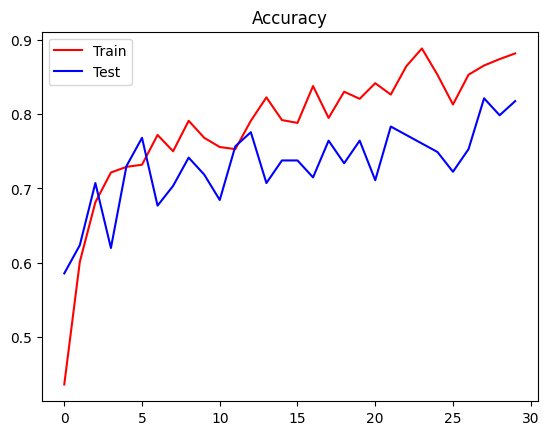

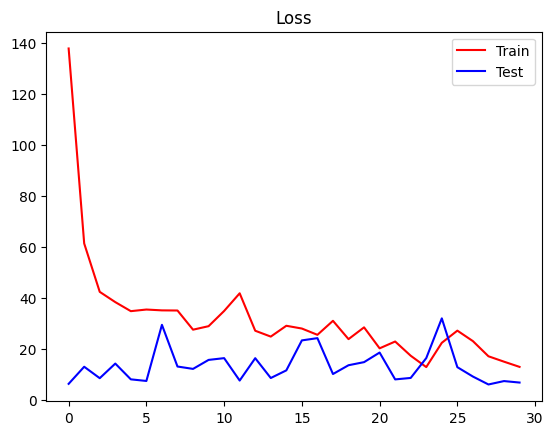

In [77]:
plot2l(accuracies2['Train'], accuracies2['Test'],'Train', 'Test', 'Accuracy')
plot2l(losses2['Train'], losses2['Test'], 'Train', 'Test', 'Loss')

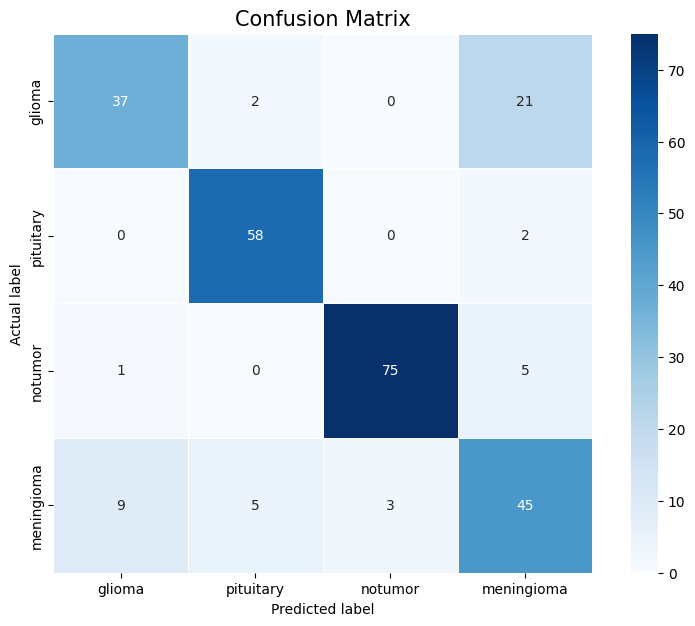

In [78]:
plot_confusion_matrix(categories ,confusion_matrix_test2)

In [79]:
metrics_per_class2, average_metrics2 = calculate_classification_metrics(categories, confusion_matrix_test2)

In [80]:
metrics_per_class2

,Genre,Accuracy,Precision,Recall,F1 Score
0,glioma,0.81749,0.787234,0.616667,0.691589
1,pituitary,0.81749,0.892308,0.966667,0.928000
2,notumor,0.81749,0.961538,0.925926,0.943396
3,meningioma,0.81749,0.616438,0.725806,0.666667


In [81]:
average_metrics2

,Metric,Macro Average,Weighted Average,Micro Average
0,Precision,0.814380,0.824625,0.81749
1,Recall,0.808766,0.817490,0.81749
2,F1 Score,0.807413,0.817201,0.81749
